<a href="https://colab.research.google.com/github/formroller/ML_clone/blob/master/kaggle/Santander/SantanderPrediction4(FE%2Bmodeling).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [SantanderPrediction](https://www.kaggle.com/gpreda/santander-eda-and-prediction#Data-exploration)


고객 만족도는 고객의 이탈 여부를 결정하는 척도가 된다. 현재 커널에서는 수백개의 익명화된 변수들을 사용해 은행 업무를 처리한느 동안 서비스 만족도가 낮은 고객 예측을 목적으로 한다.  

커널 평가는 예측값과 관찰값 사이의 ROC curver 아래 영역을 기준으로 한다.  

**필사 4회차**
Feature engineergin과 Modeling 부분에 대해 알아본다.

# 목차
1. Prepare for data analysis
2. Feature Engineering
3. Model
 * 3.1 일부 변수 제거
 * 3.2 모델 하이퍼파라미터 정의
 * 3.3 모델링
 * 3.4 Feature Importance
4. Submission

# 1.Prepare for data analysis
---


In [32]:
# from google.colab import drive
# drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/kaggle/Santander')

import gc
import logging
import warnings
import numpy as np
import pandas as pd
import  matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings('ignore')

In [21]:
%%time
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

CPU times: user 12.7 s, sys: 603 ms, total: 13.3 s
Wall time: 14 s


# 2.Feature Engineering
---
기존 변수에 몇가지 집계 시행
 - 합, 최솟값, 최댓값, 평균, 표준편차, 왜도, 첨도, 중앙값

In [22]:
%%time
idx = features = train.columns.values[2:202]
for df in [test, train]:
    df['sum'] = df[idx].sum(axis=1)
    df['min'] = df[idx].min(axis=1)
    df['max'] = df[idx].max(axis=1)
    df['mean'] = df[idx].mean(axis=1)
    df['std'] = df[idx].std(axis=1)
    df['skew'] = df[idx].skew(axis=1)
    df['kurt'] = df[idx].kurt(axis=1)
    df['mde'] = df[idx].median(axis=1)

CPU times: user 8.68 s, sys: 103 ms, total: 8.79 s
Wall time: 8.76 s


새로 생성한 변수 확인

In [23]:
train[train.columns[202:]].head()

,sum,min,max,mean,std,skew,kurt,mde
0,1456.3182,-21.4494,43.1127,7.281591,9.331540,0.101580,1.331023,6.77040
1,1415.3636,-47.3797,40.5632,7.076818,10.336130,-0.351734,4.110215,7.22315
2,1240.8966,-22.4038,33.8820,6.204483,8.753387,-0.056957,0.546438,5.89940
3,1288.2319,-35.1659,38.1015,6.441159,9.594064,-0.480116,2.630499,6.70260
4,1354.2310,-65.4863,41.1037,6.771155,11.287122,-1.463426,9.787399,6.94735


In [24]:
test[test.columns[201:]].head()

,sum,min,max,mean,std,skew,kurt,mde
0,1416.6404,-31.9891,42.0248,7.083202,9.910632,-0.088518,1.871262,7.31440
1,1249.6860,-41.1924,35.6020,6.248430,9.541267,-0.559785,3.391068,6.43960
2,1430.2599,-34.3488,39.3654,7.151299,9.967466,-0.135084,2.326901,7.26355
3,1411.4447,-21.4797,40.3383,7.057223,8.257204,-0.167741,2.253054,6.89675
4,1423.7364,-24.8254,45.5510,7.118682,10.043542,0.293484,2.044943,6.83375


In [39]:
def plot_new_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(2,4, figsize=(18,8))

    for feature in features:
        i += 1
        plt.subplot(2,4,i)
        sns.kdeplot(df1[feature], bw=0.5, label = label1)
        sns.kdeplot(df2[feature], bw=0.5, label = label2)
        plt.xlabel(feature, fontsize=11)
        locs, label = plt.xticks()

        plt.tick_params(axis='x', which='major', labelsize=8)
        plt.tick_params(axis='y', which='major', labelsize=8)

    plt.show()

새로 생성한 변수의 분포를 확인하고 가공한다.  
Target값에 따라(0,1) 그룹화된 새로운 특징의 분포를 그림으로 표시한다.

<Figure size 432x288 with 0 Axes>

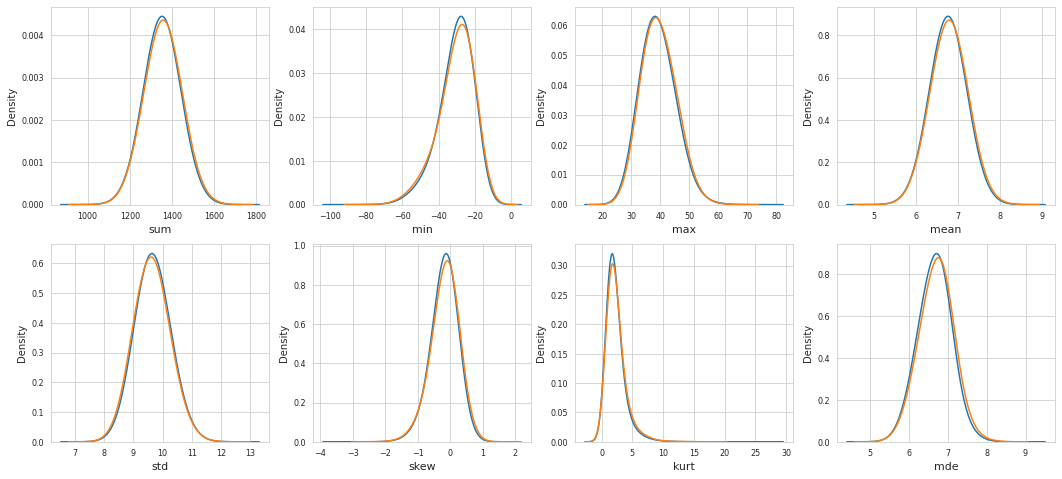

In [40]:
# train - target 기준
t0 = train.loc[train['target']==0]
t1 = train.loc[train['target']==1]

features = train.columns.values[202:]
plot_new_feature_distribution(t0, t1, 'tareget:0', 'target:1', features)

<Figure size 432x288 with 0 Axes>

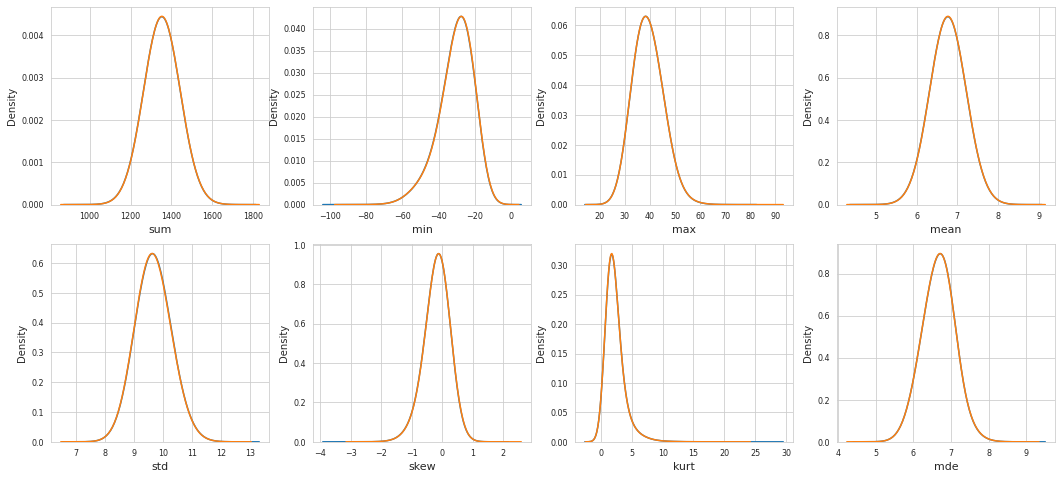

In [42]:
# train / test
features = train.columns.values[202:]
plot_new_feature_distribution(train, test, 'train', 'test', features)

# 3.Model
---

## 3.1 일부 변수 제거

In [44]:
features = [c for c in train.columns if c not in ['ID_code','target']]
target = train['target']

## 3.2 모델 하이퍼파라미터 정의

In [48]:
param = {
    'bagging_freq':5,
    'bagging_fraction':0.4,
    'boost_from_average':'false',
    'boost':'gbdt',
    'feature_fraction':0.05,
    'learning_rate':0.01,
    'max_depth':-1,
    'metric':'auc',
    'min_data_in_leaf':80,
    'min_sum_hessian_in_leaf':10.0,
    'num_leaves':13,
    'num_thread':8,
    'tree_learner':'serial',
    'objective':'binary',
    'verbosity':1
    }

## 5.3 모델링

In [52]:
# fold = 8, num_round = 100000

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(train))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print(f"Fold {fold_}")
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label = target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label = target.iloc[val_idx])

    num_round = 100000
    clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data], verbose_eval=1000, early_stopping_rounds=3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration = clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df['Feature'] = features
    fold_importance_df['importance'] = clf.feature_importance()
    fold_importance_df['fold'] = fold_ + 1
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    predictions += clf.predict(test[features], num_iteration = clf.best_iteration)/folds.n_splits

print('CV score : {:<8.5f}'.format(roc_auc_score(target, oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.901701	valid_1's auc: 0.883556
[2000]	training's auc: 0.913097	valid_1's auc: 0.891667
[3000]	training's auc: 0.920958	valid_1's auc: 0.895798
[4000]	training's auc: 0.927117	valid_1's auc: 0.898189
[5000]	training's auc: 0.93234	valid_1's auc: 0.899554
[6000]	training's auc: 0.936928	valid_1's auc: 0.900308
[7000]	training's auc: 0.941137	valid_1's auc: 0.900689
[8000]	training's auc: 0.94509	valid_1's auc: 0.90087
[9000]	training's auc: 0.94879	valid_1's auc: 0.901047
[10000]	training's auc: 0.95236	valid_1's auc: 0.901073
[11000]	training's auc: 0.955788	valid_1's auc: 0.901051
[12000]	training's auc: 0.958991	valid_1's auc: 0.901011
[13000]	training's auc: 0.962119	valid_1's auc: 0.900971
[14000]	training's auc: 0.965013	valid_1's auc: 0.900819
Early stopping, best iteration is:
[11536]	training's auc: 0.957495	valid_1's auc: 0.901124
Fold 1
Training until validation scores don't improve

## 3.4 Feature Impotrance

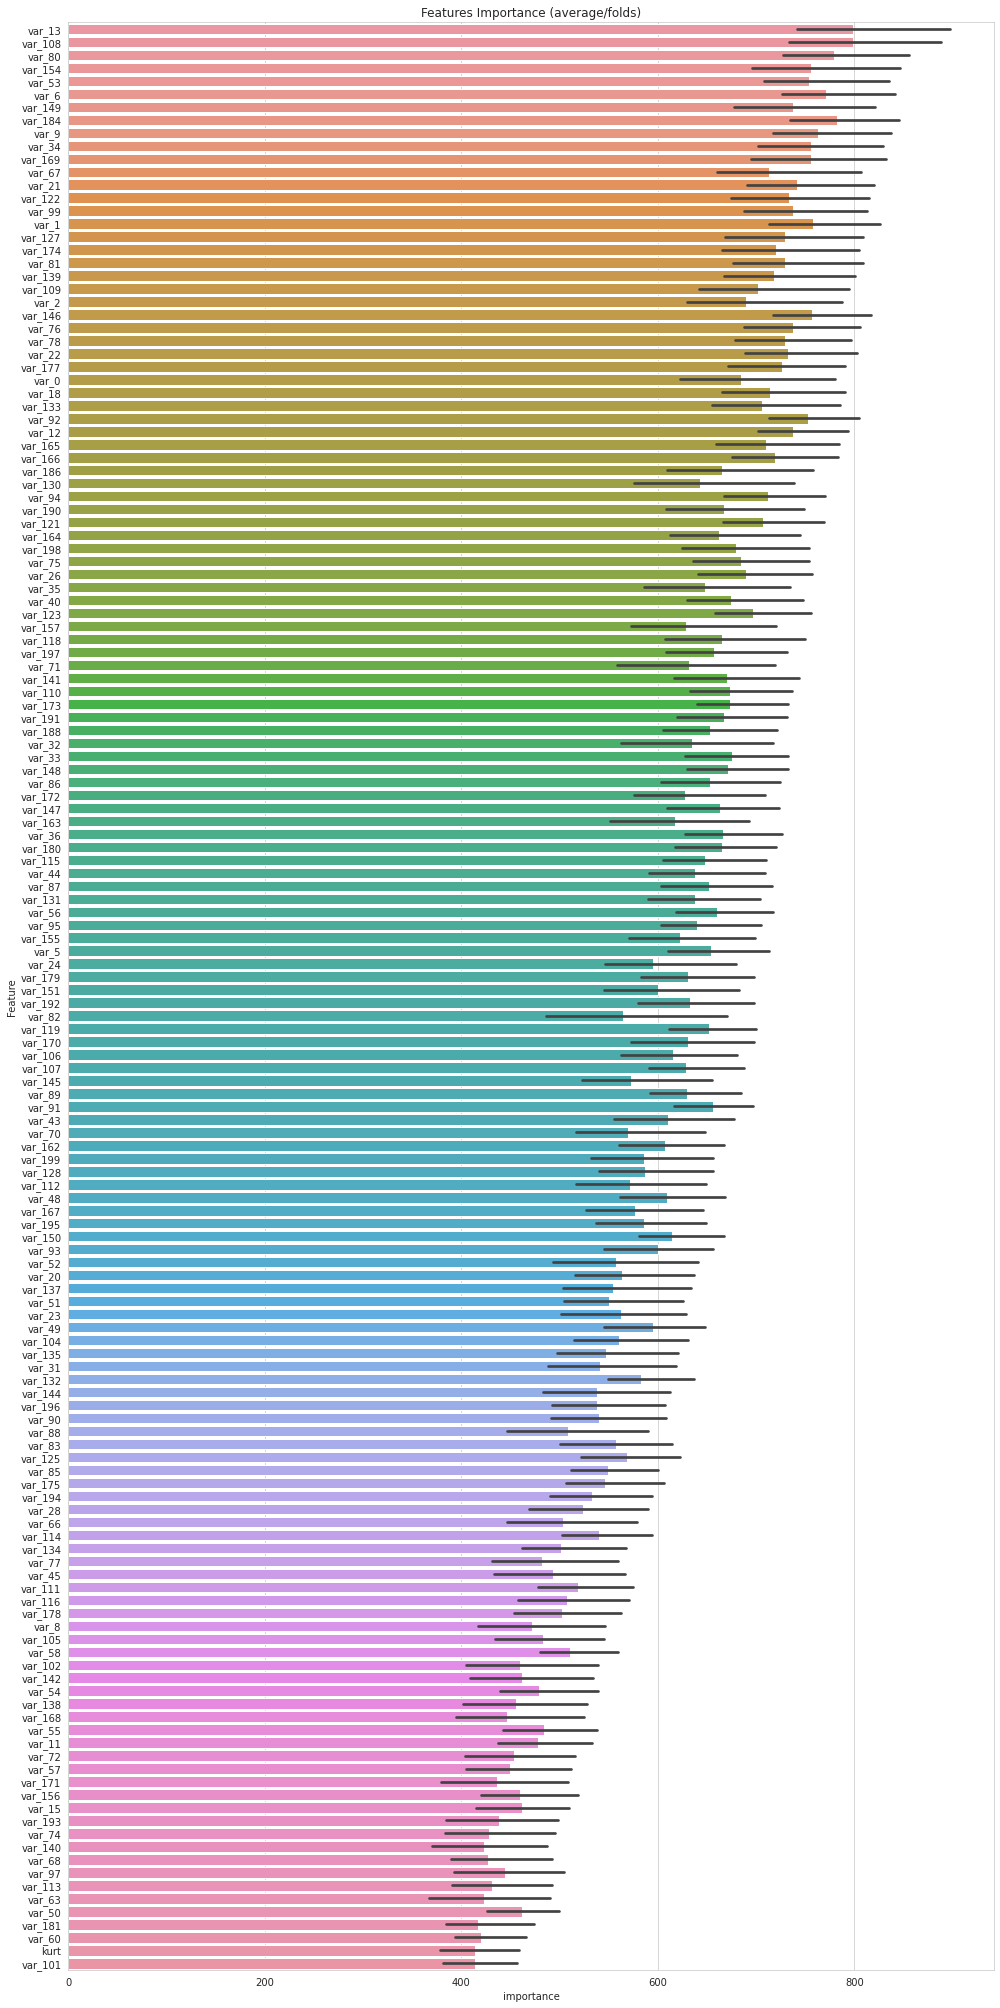

In [55]:
cols = (feature_importance_df[['Feature','importance']]).groupby('Feature').mean().sort_values(by='importance', ascending=False)[:150].index
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x='importance', y='Feature', data = best_features.sort_values(by='importance', ascending=False))
plt.title('Features Importance (average/folds)')
plt.tight_layout()

# 4.Submission

In [57]:
pd.DataFrame({'ID_code':test['ID_code'].values, 'target':predictions})

,ID_code,target
0,test_0,0.115743
1,test_1,0.202161
2,test_2,0.193983
3,test_3,0.213619
4,test_4,0.041774
...,...,...
199995,test_199995,0.035430
199996,test_199996,0.008356
199997,test_199997,0.004964
199998,test_199998,0.097177
